In [6]:
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
from skimage.transform import rescale
from skimage.color import rgb2gray, gray2rgb
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split
from torchvision import transforms, utils
import random
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import time
import cv2

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [8]:
dataframe=pd.read_csv('list.csv')

In [9]:
def image_transform(image):
    #Construct the mask
    mask=np.zeros((128,128,3))
    mask[48:80,48:80]=1
    
    image=image/np.amax(image) #All entries of image between 0 and 1
    image=rescale(image,0.5,anti_aliasing=True,multichannel=True) # Rescale image to 128*128*3
    if (image.shape==mask.shape):
        i=np.multiply(image,np.ones(mask.shape)-mask) #Find the unmasked portion
        mu=np.zeros((128,128,3))
        mu[:,:,0]=np.mean(i[:,:,0]) #Calculate the mean over unmasked portion
        mu[:,:,1]=np.mean(i[:,:,1])
        mu[:,:,2]=np.mean(i[:,:,2])
        im=mu*mask+i #Set the outer pixel of channel to mean value calculated above
        gray_img = rgb2gray(mask) 
        ip=np.dstack((im,gray_img)) #Stack final image with the mask
        if (image is not None and ip is not None and mask is not None):
            return (image,ip,mask)

In [10]:
class PlacesDataset(Dataset):
    def __init__(self,df,img_dir,transform=None):
        self.df=df
        self.img_dir=img_dir
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        img_path=os.path.join(self.img_dir,'{}'.format(self.df.loc[idx]['image']))
        if(img_path is not None):
            image=io.imread(img_path)
            if (image is not None):
                image,tr_image,mask=image_transform(image)
                sample={'orig_image':image,'new_image':tr_image,'mask':mask}
                if self.transform:
                    sample['orig_image']=self.transform(sample['orig_image'])
                    sample['new_image']=self.transform(sample['new_image'])
                    sample['mask']=self.transform(sample['mask'])
        
                return sample

In [11]:
dataset=PlacesDataset(dataframe,img_dir='images/test_256/',transform=transforms.Compose([transforms.ToTensor()]))

In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [13]:
random.seed(0)
num_train=len(dataset)
indices=list(range(num_train))
test_idx = indices[-210:]
train_idx = list(set(indices) - set(test_idx))
test_data = Subset(dataset,test_idx)
train_data=Subset(dataset,train_idx)
validation_data,test_data=random_split(test_data,(20,190))
a=len(train_data)-75000
train_phase_1,train_phase_2,train_phase_3=random_split(train_data,(70000,5000,a))

In [14]:
train_loader_p1 = torch.utils.data.DataLoader(train_phase_1,batch_size=100)
train_loader_p2 = torch.utils.data.DataLoader(train_phase_2,batch_size=100)
train_loader_p3 = torch.utils.data.DataLoader(train_phase_3,batch_size=100)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=1)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1)

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1=nn.Conv2d(in_channels=4,out_channels=64,kernel_size=3,dilation=1,stride=1,padding=1)
        self.norm1=nn.BatchNorm2d(num_features=64)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=2,dilation=1,stride=2,padding=0)
        self.norm2=nn.BatchNorm2d(num_features=128)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=2,dilation=1,stride=2,padding=0)
        self.norm3=nn.BatchNorm2d(num_features=256)
        self.conv4=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=1,stride=1,padding=1)
        self.norm4=nn.BatchNorm2d(num_features=256)
        self.conv5=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=2,stride=1,padding=2)
        self.norm5=nn.BatchNorm2d(num_features=256)
        self.conv6=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=4,stride=1,padding=4)
        self.norm6=nn.BatchNorm2d(num_features=256)
        self.conv7=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=4,stride=1,padding=4)
        self.norm7=nn.BatchNorm2d(num_features=256)
        self.conv8=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=8,stride=1,padding=8)
        self.norm8=nn.BatchNorm2d(num_features=256)
        self.conv9=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=16,stride=1,padding=16)
        self.norm9=nn.BatchNorm2d(num_features=256)
        self.conv10=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=1,stride=1,padding=1)
        self.norm10=nn.BatchNorm2d(num_features=256)
        self.conv11=nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,dilation=1,stride=2,padding=1)
        self.norm11=nn.BatchNorm2d(num_features=128)
        self.conv12=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,dilation=1,stride=1,padding=1)
        self.norm12=nn.BatchNorm2d(num_features=128)
        self.conv13=nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,dilation=1,stride=2,padding=1)
        self.norm13=nn.BatchNorm2d(num_features=64)
        self.conv14=nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,dilation=1,stride=1,padding=1)
        self.norm14=nn.BatchNorm2d(num_features=32)
        self.conv15=nn.Conv2d(in_channels=32,out_channels=3,kernel_size=3,dilation=1,stride=1,padding=1)
        self.relu=nn.ReLU()
        self.sigm=nn.Sigmoid()
        
    def forward(self,x):
        x=x.type(torch.cuda.FloatTensor)
        out=self.conv1(x)
        out=self.relu(out)
        out=self.norm1(out)
        out=self.conv2(out)
        out=self.relu(out)
        out=self.norm2(out)
        out=self.conv3(out)
        out=self.relu(out)
        out=self.norm3(out)
        out=self.conv4(out)
        out=self.relu(out)
        out=self.norm4(out)
        out=self.conv5(out)
        out=self.relu(out)
        out=self.norm5(out)
        out=self.conv6(out)
        out=self.relu(out)
        out=self.norm6(out)
        out=self.conv7(out)
        out=self.relu(out)
        out=self.norm7(out)
        out=self.conv8(out)
        out=self.relu(out)
        out=self.norm8(out)
        out=self.conv9(out)
        out=self.relu(out)
        out=self.norm9(out)
        out=self.conv10(out)
        out=self.relu(out)
        out=self.norm10(out)
        out=self.conv11(out)
        out=self.relu(out)
        out=self.norm11(out)
        out=self.conv12(out)
        out=self.relu(out)
        out=self.norm12(out)
        out=self.conv13(out)
        out=self.relu(out)
        out=self.norm13(out)
        out=self.conv14(out)
        out=self.relu(out)
        out=self.norm14(out)
        
        out=self.conv15(out)
        out=self.sigm(out)
        
        return out

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1g=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,dilation=1,stride=2)
        self.norm1g=nn.BatchNorm2d(num_features=32)
        self.conv2g=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,dilation=1,stride=2)
        self.norm2g=nn.BatchNorm2d(num_features=64)
        self.conv3g=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,dilation=1,stride=2)
        self.norm3g=nn.BatchNorm2d(num_features=128)
        self.conv4g=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,dilation=1,stride=2)
        self.norm4g=nn.BatchNorm2d(num_features=256)
        self.conv5g=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=5,dilation=1,stride=2)
        
        self.conv1l=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,dilation=1,stride=2)
        self.norm1l=nn.BatchNorm2d(num_features=32)
        self.conv2l=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,dilation=1,stride=2)
        self.norm2l=nn.BatchNorm2d(num_features=64)
        self.conv3l=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,dilation=1,stride=2)
        self.norm3l=nn.BatchNorm2d(num_features=128)
        self.conv4l=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,dilation=1,stride=2)
        
        self.fc=nn.Linear(768,1)
        self.relu=nn.ReLU()
        self.sigm=nn.Sigmoid()
        
    def forward(self,x):
        x=x.type(torch.cuda.FloatTensor)
        out_g=self.conv1g(x)
        out_g=self.relu(out_g)
        out_g=self.norm1g(out_g)
        out_g=self.conv2g(out_g)
        out_g=self.relu(out_g)
        out_g=self.norm2g(out_g)
        out_g=self.conv3g(out_g)
        out_g=self.relu(out_g)
        out_g=self.norm3g(out_g)
        out_g=self.conv4g(out_g)
        out_g=self.relu(out_g)
        out_g=self.norm4g(out_g)
        out_g=self.conv5g(out_g)
        out_g=self.relu(out_g)
        out_g=out_g.view(-1,512)
        
        
        y=x[:,:,32:96,32:96]
        out_l=self.conv1l(y)
        out_l=self.relu(out_l)
        out_l=self.norm1l(out_l)
        out_l=self.conv2l(out_l)
        out_l=self.relu(out_l)
        out_l=self.norm2l(out_l)
        out_l=self.conv3l(out_l)
        out_l=self.relu(out_l)
        out_l=self.norm3l(out_l)
        out_l=self.conv4l(out_l)
        out_l=self.relu(out_l)
        out_l=out_l.view(-1,256)
        
        out=torch.cat((out_g,out_l),1)
        out=self.relu(out)
        out=self.fc(out)
        out=self.sigm(out)
        
        return out

In [17]:
def train_discriminator(model,train_loader,d_optimizer,d_criterion,epoch,num_epochs,epochs,rl_d_fake,rl_d_real):
    running_loss_real=0
    running_loss_fake=0
    discriminator.train()
    for i,(sample) in enumerate(train_loader):
        i_p=Variable(sample['new_image']).to(device)
        i_n=Variable(sample['orig_image']).to(device)
        mask=Variable(sample['mask']).to(device)
        mask=mask.type(torch.cuda.FloatTensor)
        i_p=i_p.type(torch.cuda.FloatTensor)
        d_optimizer.zero_grad()
        i_o=generator(i_p).detach()
        i_p[:,:,48:80,48:80]=0
        img=torch.mul(i_o,mask)+i_p[:,0:3,:,:]
        d_i_o=discriminator(img)
        d_i_n=discriminator(i_n)
        
        loss_real=d_criterion(d_i_n,ones_target(100).to(device))
        loss_real.backward()
        rl_d_real.append(loss_real.item())
        
        loss_fake=d_criterion(d_i_o,zeros_target(100).to(device))
        loss_fake.backward()
        rl_d_fake.append(loss_fake.item())
        
        d_optimizer.step()
        
        running_loss_real+=loss_real.item()
        running_loss_fake+=loss_fake.item()
        if((i+1)%10==0):
            print('Epoch: [{}/{}] | Step: [{}/{}] | Loss_Real: {} | Loss_fake: {} | Total loss: {}'.format(epoch+1-epochs, num_epochs, int((i+1)/10),5 , round(running_loss_real/10,6), round(running_loss_fake/10,6), round((running_loss_real+running_loss_fake)/10,6)))
            running_loss_real=0
            running_loss_fake=0

In [18]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [19]:
generator = Generator()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
generator=generator.to(device)
g_criterion = nn.MSELoss()
g_optimizer = torch.optim.Adam(generator.parameters())

cuda:0


In [20]:
discriminator=Discriminator()
discriminator=discriminator.to(device)
d_criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters())

In [21]:
checkpoint = torch.load('Generator/model_7.pth')
generator.load_state_dict(checkpoint['model_state_dict'])
g_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs_gen = checkpoint['epoch']
rl_g = checkpoint['loss']

generator.eval()

Generator(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (norm5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
  (norm6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [ ]:
#num_epochs_dis=10
#checkpoint = torch.load('Discriminator/dis_model_1.pth')
#discriminator.load_state_dict(checkpoint['model_state_dict'])
#d_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epochs_dis = checkpoint['epoch']
#rl_d = checkpoint['loss']

#discriminator.eval()

In [22]:
num_epochs_dis=5
epochs_dis=0
rl_d_fake=[]
rl_d_real=[]
for epoch_dis in range(epochs_dis,num_epochs_dis+epochs_dis):
    train_discriminator(discriminator,train_loader_p2,d_optimizer,d_criterion,epoch_dis,num_epochs_dis,epochs_dis,rl_d_fake,rl_d_real)
    print ('%---Saving the model---%')
    torch.save({
            'epoch': int(epoch_dis+1),
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'Fake loss': rl_d_fake,
            'Real loss': rl_d_real,
            },'Discriminator/model_{}.pth'.format(epoch_dis+1))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch: [1/5] | Step: [1/5] | Loss_Real: 0.280224 | Loss_fake: 0.127712 | Total loss: 0.407936
Epoch: [1/5] | Step: [2/5] | Loss_Real: 0.038523 | Loss_fake: 0.034399 | Total loss: 0.072922
Epoch: [1/5] | Step: [3/5] | Loss_Real: 0.013744 | Loss_fake: 0.014754 | Total loss: 0.028498
Epoch: [1/5] | Step: [4/5] | Loss_Real: 0.011098 | Loss_fake: 0.014285 | Total loss: 0.025383
Epoch: [1/5] | Step: [5/5] | Loss_Real: 0.017282 | Loss_fake: 0.033248 | Total loss: 0.05053
%---Saving the model---%
Epoch: [2/5] | Step: [1/5] | Loss_Real: 0.012198 | Loss_fake: 0.021596 | Total loss: 0.033794
Epoch: [2/5] | Step: [2/5] | Loss_Real: 0.010396 | Loss_fake: 0.021831 | Total loss: 0.032227
Epoch: [2/5] | Step: [3/5] | Loss_Real: 0.031915 | Loss_fake: 0.016068 | Total loss: 0.047983
Epoch: [2/5] | Step: [4/5] | Loss_Real: 0.018862 | Loss_fake: 0.014284 | Total loss: 0.033146
Epoch: [2/5] | Step: [5/5] | Loss_Real: 0.009049 | Loss_fake: 0.002206 | Total loss: 0.011255
%---Saving the model---%
Epoch: [3/5

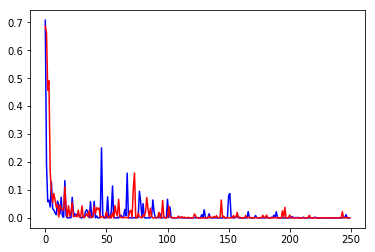

In [23]:
plt.plot(range(len(rl_d_fake)),rl_d_fake,color='blue')
plt.plot(range(len(rl_d_real)),rl_d_real,color='red')
plt.show()